# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [ ]:
# run this once to unzip the file
!unzip processed-celeba-small.zip

Archive:  processed-celeba-small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [37]:
from glob import glob
from typing import Tuple, Callable, Dict
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize , CenterCrop

import pathlib
import tests

In [38]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [39]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    transforms = [Resize(size[0]),
                  CenterCrop(size[0]),
                  ToTensor()
                  ]
    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [40]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        
        self.img_dir = list(pathlib.Path(directory).glob('*'+extension))
        self.transform = transforms
        # TODO: implement the init method

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # TODO: return the number of elements in the dataset
        return len(self.img_dir)

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        # TODO: return the index-element of the dataset
        image_path = self.img_dir[index]
        img = Image.open(image_path)
        image = self.transform(img)
        return image

In [41]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

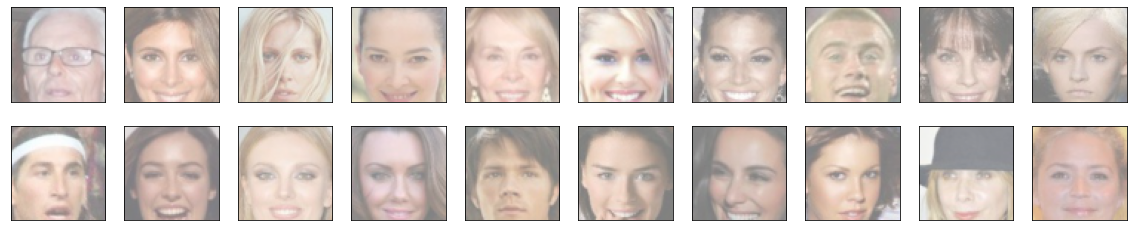

In [42]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [43]:
from torch.nn import Module
import torch.nn as nn

In [44]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    ####
    arr_min, arr_max = feature_range
    x = x * (arr_max - arr_min) + arr_min
    ####
    return x

In [45]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

In [47]:
class ConvBlock(Module):
    """
    A convolutional block is made of 3 layers: Conv -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, batch_norm: bool = True):
        super(ConvBlock, self).__init__()
        
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = torch.nn.BatchNorm2d(out_channels)
        self.activation = torch.nn.LeakyReLU(0.2)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [48]:
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # TODO: instantiate the different layers
         # complete init function
        ndf = 64
        nc = 3
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            #nn.Dropout(p=0.2),
            #nn.Linear(ndf*4*4, 1),
            #nn.Sigmoid()
        )
#nn.Sigmoid()


      
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        x = self.main(x)      
        return x 

In [49]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [50]:
class Generator(Module):
    def __init__(self, latent_dim: int):
        super(Generator, self).__init__()
        # TODO: instantiate the different layers
        ngf = 64
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( latent_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        x = self.main(x)
        return x

In [51]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [52]:
import torch.optim as optim


def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    lr = 0.0002
    beta1 = 0.5
    beta2 = 0.999

    g_optimizer = torch.optim.Adam(generator.parameters(), lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr, [beta1, beta2])
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [53]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU')
else:
    print('Training on GPU!')

import torch.nn as nn




Training on GPU!


In [54]:
def generator_loss(fake_logits):
    """ Generator loss with BCE, takes the fake scores as inputs. """
    loss_fn = nn.BCELoss() 
    target = torch.ones_like(fake_logits)  # Target labels are all ones (real)
    loss = loss_fn(fake_logits, target) 
    return loss

In [55]:
def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [56]:
def discriminator_loss(real_logits, fake_logits):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    # TODO: implement the discriminator loss 
    """
    Wasserstein Discriminator Loss
    
    args:
    - real_logits: vector of logits outputed by the discriminator with a real input image
    - fake_logits: vector of logits outputed by the discriminator with a fake input image 
    """
    ####
    real_loss = -real_logits.mean()
    fake_loss = fake_logits.mean()
    loss = real_loss + fake_loss
    ####
    return loss

In [57]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [58]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """ This function enforces """
    gp = 0
    # TODO (Optional): implement the gradient penalty
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [59]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    # TODO: implement the generator step (foward pass, loss calculation and backward pass)
    g_optimizer.zero_grad()
    z= np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    z= torch.from_numpy(z).float()
    
    if train_on_gpu:
        z = z.cuda()
            
    fake_images = generator(z)
        
    D_fake = discriminator(fake_images)
    g_loss = real_loss(D_fake, True)
    g_loss.backward()
    g_optimizer.step()
    
    return {'loss': g_loss}


def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
    # TODO: implement the discriminator step (foward pass, loss calculation and backward pass)
    d_optimizer.zero_grad()
    D_real = discriminator(real_images)
    

    z = np.random.uniform(-1, 1, size=(batch_size, latent_dim, 1, 1))
    z = torch.from_numpy(z).float()
    
    if train_on_gpu:
        z = z.cuda()
    
    fake_images = generator(z)
    
    D_fake = discriminator(fake_images.detach())
    
    d_real_loss = real_loss(D_real, True)
    
    d_fake_loss = fake_loss(D_fake) 
    d_loss = d_real_loss + d_fake_loss
    d_loss.backward()
    d_optimizer.step()
    
    return {'loss': d_loss, 'gp': 0}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [60]:
from datetime import datetime
import pickle as pkl


In [61]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 25

# number of images in each batch
batch_size = 64

In [62]:
import torch
torch.cuda.is_available()  # Should return True if setup is correct
torch.cuda.get_device_name(0) # Should print your GPU device name   


'Tesla T4'

In [63]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [64]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

In [66]:
def save_model(discriminator, generator, d_optimizer, g_optimizer, filename="face_dcgan_model.pt"):
    data = dict(
        discriminator=discriminator,
        generator=generator,
        d_optimizer=d_optimizer,
        g_optimizer=g_optimizer
    )
    torch.save(data, filename)

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

2024-03-27 20:45:08 | Epoch [1/25] | Batch 0/509 | d_loss: 1.0287 | g_loss: 3.4581
2024-03-27 20:45:15 | Epoch [1/25] | Batch 50/509 | d_loss: 0.5857 | g_loss: 5.9535
2024-03-27 20:45:22 | Epoch [1/25] | Batch 100/509 | d_loss: 0.6886 | g_loss: 4.4659
2024-03-27 20:45:28 | Epoch [1/25] | Batch 150/509 | d_loss: 0.8689 | g_loss: 2.7657
2024-03-27 20:45:35 | Epoch [1/25] | Batch 200/509 | d_loss: 1.0037 | g_loss: 6.3027
2024-03-27 20:45:42 | Epoch [1/25] | Batch 250/509 | d_loss: 1.1418 | g_loss: 1.1808
2024-03-27 20:45:49 | Epoch [1/25] | Batch 300/509 | d_loss: 0.6783 | g_loss: 4.4639
2024-03-27 20:45:56 | Epoch [1/25] | Batch 350/509 | d_loss: 0.6974 | g_loss: 5.4410
2024-03-27 20:46:02 | Epoch [1/25] | Batch 400/509 | d_loss: 1.7871 | g_loss: 1.9506
2024-03-27 20:46:09 | Epoch [1/25] | Batch 450/509 | d_loss: 0.7542 | g_loss: 3.6180
2024-03-27 20:46:15 | Epoch [1/25] | Batch 500/509 | d_loss: 0.5882 | g_loss: 4.7023


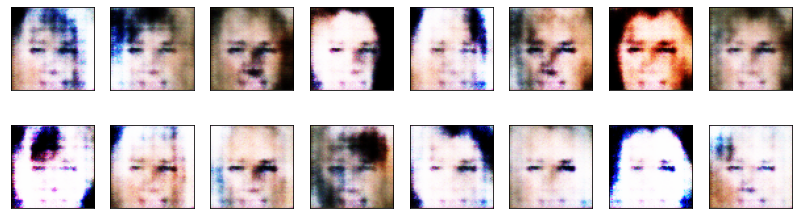

2024-03-27 20:46:20 | Epoch [2/25] | Batch 0/509 | d_loss: 0.4571 | g_loss: 2.6580
2024-03-27 20:46:27 | Epoch [2/25] | Batch 50/509 | d_loss: 0.9646 | g_loss: 3.6515
2024-03-27 20:46:34 | Epoch [2/25] | Batch 100/509 | d_loss: 0.6902 | g_loss: 2.5928
2024-03-27 20:46:41 | Epoch [2/25] | Batch 150/509 | d_loss: 0.6835 | g_loss: 2.6100
2024-03-27 20:46:47 | Epoch [2/25] | Batch 200/509 | d_loss: 0.6271 | g_loss: 3.2451
2024-03-27 20:46:54 | Epoch [2/25] | Batch 250/509 | d_loss: 0.6929 | g_loss: 2.4929
2024-03-27 20:47:01 | Epoch [2/25] | Batch 300/509 | d_loss: 0.6851 | g_loss: 4.0442
2024-03-27 20:47:08 | Epoch [2/25] | Batch 350/509 | d_loss: 0.7753 | g_loss: 2.8402
2024-03-27 20:47:14 | Epoch [2/25] | Batch 400/509 | d_loss: 0.7957 | g_loss: 2.2441
2024-03-27 20:47:21 | Epoch [2/25] | Batch 450/509 | d_loss: 0.7391 | g_loss: 3.9118
2024-03-27 20:47:28 | Epoch [2/25] | Batch 500/509 | d_loss: 0.5612 | g_loss: 3.0816


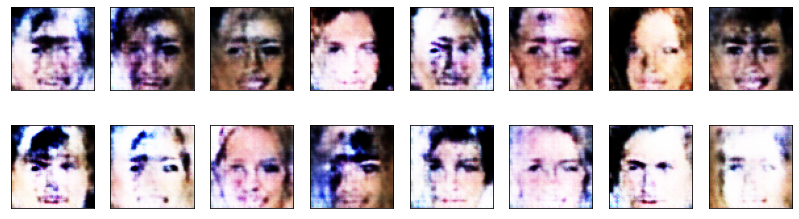

2024-03-27 20:47:33 | Epoch [3/25] | Batch 0/509 | d_loss: 0.7613 | g_loss: 1.6565
2024-03-27 20:47:40 | Epoch [3/25] | Batch 50/509 | d_loss: 0.8321 | g_loss: 2.8050
2024-03-27 20:47:47 | Epoch [3/25] | Batch 100/509 | d_loss: 0.5862 | g_loss: 3.0914
2024-03-27 20:47:53 | Epoch [3/25] | Batch 150/509 | d_loss: 0.6640 | g_loss: 2.5669
2024-03-27 20:48:00 | Epoch [3/25] | Batch 200/509 | d_loss: 0.7698 | g_loss: 4.4763
2024-03-27 20:48:07 | Epoch [3/25] | Batch 250/509 | d_loss: 0.6773 | g_loss: 2.2975
2024-03-27 20:48:14 | Epoch [3/25] | Batch 300/509 | d_loss: 0.5134 | g_loss: 3.1344
2024-03-27 20:48:21 | Epoch [3/25] | Batch 350/509 | d_loss: 0.6785 | g_loss: 2.5624
2024-03-27 20:48:27 | Epoch [3/25] | Batch 400/509 | d_loss: 0.5822 | g_loss: 2.7977
2024-03-27 20:48:34 | Epoch [3/25] | Batch 450/509 | d_loss: 0.7105 | g_loss: 2.3103
2024-03-27 20:48:41 | Epoch [3/25] | Batch 500/509 | d_loss: 0.5453 | g_loss: 3.1234


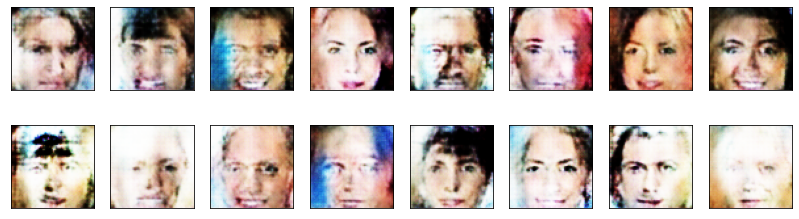

2024-03-27 20:48:46 | Epoch [4/25] | Batch 0/509 | d_loss: 0.6436 | g_loss: 2.6894
2024-03-27 20:48:53 | Epoch [4/25] | Batch 50/509 | d_loss: 0.8011 | g_loss: 1.8676
2024-03-27 20:49:00 | Epoch [4/25] | Batch 100/509 | d_loss: 0.6829 | g_loss: 3.1965
2024-03-27 20:49:06 | Epoch [4/25] | Batch 150/509 | d_loss: 0.8196 | g_loss: 5.1274
2024-03-27 20:49:13 | Epoch [4/25] | Batch 200/509 | d_loss: 0.4877 | g_loss: 2.9220
2024-03-27 20:49:20 | Epoch [4/25] | Batch 250/509 | d_loss: 0.6706 | g_loss: 3.8937
2024-03-27 20:49:27 | Epoch [4/25] | Batch 300/509 | d_loss: 0.5862 | g_loss: 2.6646
2024-03-27 20:49:33 | Epoch [4/25] | Batch 350/509 | d_loss: 0.4541 | g_loss: 3.3402
2024-03-27 20:49:40 | Epoch [4/25] | Batch 400/509 | d_loss: 0.7665 | g_loss: 2.5854
2024-03-27 20:49:47 | Epoch [4/25] | Batch 450/509 | d_loss: 0.8094 | g_loss: 3.9186
2024-03-27 20:49:53 | Epoch [4/25] | Batch 500/509 | d_loss: 0.8590 | g_loss: 1.7348


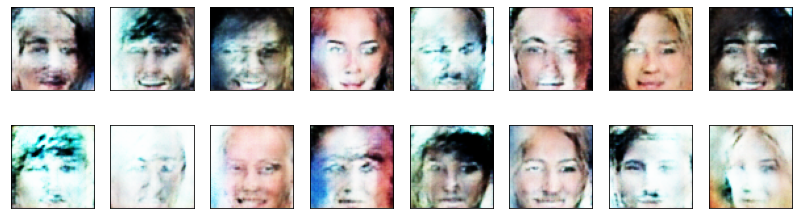

2024-03-27 20:49:59 | Epoch [5/25] | Batch 0/509 | d_loss: 0.7050 | g_loss: 3.1858
2024-03-27 20:50:05 | Epoch [5/25] | Batch 50/509 | d_loss: 0.7362 | g_loss: 3.0362
2024-03-27 20:50:12 | Epoch [5/25] | Batch 100/509 | d_loss: 0.5986 | g_loss: 3.4808
2024-03-27 20:50:19 | Epoch [5/25] | Batch 150/509 | d_loss: 0.7327 | g_loss: 4.5518
2024-03-27 20:50:25 | Epoch [5/25] | Batch 200/509 | d_loss: 0.9168 | g_loss: 1.6152
2024-03-27 20:50:32 | Epoch [5/25] | Batch 250/509 | d_loss: 0.5477 | g_loss: 3.3586
2024-03-27 20:50:39 | Epoch [5/25] | Batch 300/509 | d_loss: 0.7650 | g_loss: 3.4070
2024-03-27 20:50:45 | Epoch [5/25] | Batch 350/509 | d_loss: 0.5968 | g_loss: 2.8667
2024-03-27 20:50:52 | Epoch [5/25] | Batch 400/509 | d_loss: 0.5136 | g_loss: 2.7429
2024-03-27 20:50:59 | Epoch [5/25] | Batch 450/509 | d_loss: 0.6498 | g_loss: 3.1564
2024-03-27 20:51:05 | Epoch [5/25] | Batch 500/509 | d_loss: 0.5620 | g_loss: 3.2138


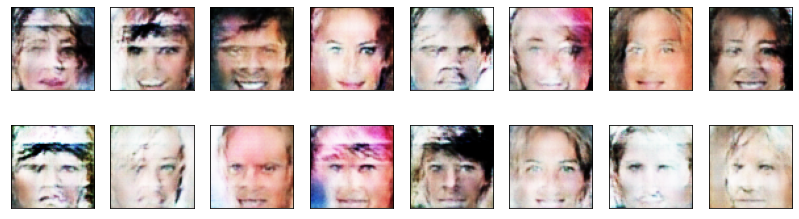

2024-03-27 20:51:11 | Epoch [6/25] | Batch 0/509 | d_loss: 0.4854 | g_loss: 3.7125
2024-03-27 20:51:18 | Epoch [6/25] | Batch 50/509 | d_loss: 0.6281 | g_loss: 3.0541
2024-03-27 20:51:24 | Epoch [6/25] | Batch 100/509 | d_loss: 0.4258 | g_loss: 3.8707
2024-03-27 20:51:31 | Epoch [6/25] | Batch 150/509 | d_loss: 0.6239 | g_loss: 2.3923
2024-03-27 20:51:38 | Epoch [6/25] | Batch 200/509 | d_loss: 0.5168 | g_loss: 2.4773
2024-03-27 20:51:44 | Epoch [6/25] | Batch 250/509 | d_loss: 0.4660 | g_loss: 3.2270
2024-03-27 20:51:51 | Epoch [6/25] | Batch 300/509 | d_loss: 0.6324 | g_loss: 3.3477
2024-03-27 20:51:58 | Epoch [6/25] | Batch 350/509 | d_loss: 0.6138 | g_loss: 2.8397
2024-03-27 20:52:05 | Epoch [6/25] | Batch 400/509 | d_loss: 0.6287 | g_loss: 3.6431
2024-03-27 20:52:11 | Epoch [6/25] | Batch 450/509 | d_loss: 0.5704 | g_loss: 2.5308
2024-03-27 20:52:18 | Epoch [6/25] | Batch 500/509 | d_loss: 0.5442 | g_loss: 3.3891


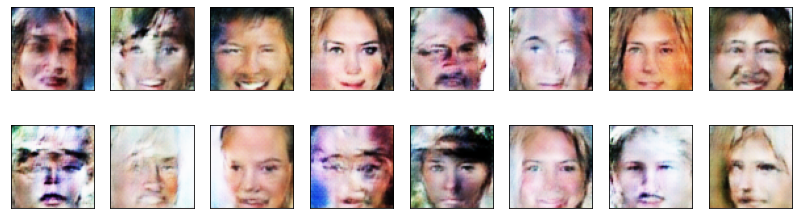

2024-03-27 20:52:23 | Epoch [7/25] | Batch 0/509 | d_loss: 0.5145 | g_loss: 4.2112
2024-03-27 20:52:30 | Epoch [7/25] | Batch 50/509 | d_loss: 0.5547 | g_loss: 3.4507
2024-03-27 20:52:37 | Epoch [7/25] | Batch 100/509 | d_loss: 0.4748 | g_loss: 3.1353
2024-03-27 20:52:44 | Epoch [7/25] | Batch 150/509 | d_loss: 0.4214 | g_loss: 3.3696
2024-03-27 20:52:50 | Epoch [7/25] | Batch 200/509 | d_loss: 0.5006 | g_loss: 3.2517
2024-03-27 20:52:57 | Epoch [7/25] | Batch 250/509 | d_loss: 0.4932 | g_loss: 3.3511
2024-03-27 20:53:04 | Epoch [7/25] | Batch 300/509 | d_loss: 0.6308 | g_loss: 3.5792
2024-03-27 20:53:10 | Epoch [7/25] | Batch 350/509 | d_loss: 0.4024 | g_loss: 3.9050
2024-03-27 20:53:17 | Epoch [7/25] | Batch 400/509 | d_loss: 0.4157 | g_loss: 2.9694
2024-03-27 20:53:24 | Epoch [7/25] | Batch 450/509 | d_loss: 0.5156 | g_loss: 3.0727
2024-03-27 20:53:30 | Epoch [7/25] | Batch 500/509 | d_loss: 0.5819 | g_loss: 2.3467


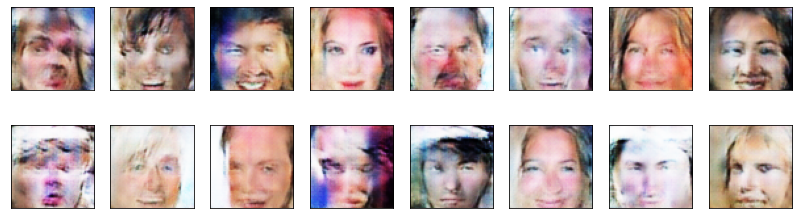

2024-03-27 20:53:35 | Epoch [8/25] | Batch 0/509 | d_loss: 0.6314 | g_loss: 2.0866
2024-03-27 20:53:42 | Epoch [8/25] | Batch 50/509 | d_loss: 0.3943 | g_loss: 4.5523
2024-03-27 20:53:49 | Epoch [8/25] | Batch 100/509 | d_loss: 1.6413 | g_loss: 3.4431
2024-03-27 20:53:56 | Epoch [8/25] | Batch 150/509 | d_loss: 0.6379 | g_loss: 4.2512
2024-03-27 20:54:02 | Epoch [8/25] | Batch 200/509 | d_loss: 0.4033 | g_loss: 3.6054
2024-03-27 20:54:09 | Epoch [8/25] | Batch 250/509 | d_loss: 1.0448 | g_loss: 3.1691
2024-03-27 20:54:16 | Epoch [8/25] | Batch 300/509 | d_loss: 0.4442 | g_loss: 3.3182
2024-03-27 20:54:22 | Epoch [8/25] | Batch 350/509 | d_loss: 1.8841 | g_loss: 5.4295
2024-03-27 20:54:29 | Epoch [8/25] | Batch 400/509 | d_loss: 0.5625 | g_loss: 3.3952
2024-03-27 20:54:36 | Epoch [8/25] | Batch 450/509 | d_loss: 0.4569 | g_loss: 3.9531
2024-03-27 20:54:42 | Epoch [8/25] | Batch 500/509 | d_loss: 0.4464 | g_loss: 3.6835


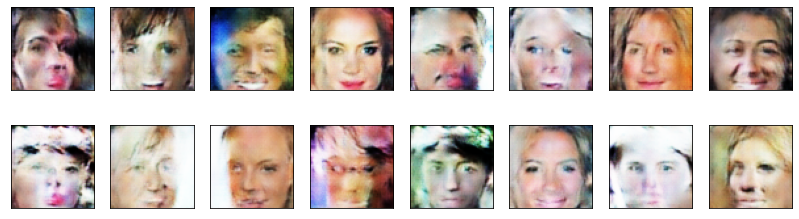

2024-03-27 20:54:48 | Epoch [9/25] | Batch 0/509 | d_loss: 0.6080 | g_loss: 3.5307
2024-03-27 20:54:55 | Epoch [9/25] | Batch 50/509 | d_loss: 0.5641 | g_loss: 3.7847
2024-03-27 20:55:01 | Epoch [9/25] | Batch 100/509 | d_loss: 0.4510 | g_loss: 2.8301
2024-03-27 20:55:08 | Epoch [9/25] | Batch 150/509 | d_loss: 0.5206 | g_loss: 3.8178
2024-03-27 20:55:15 | Epoch [9/25] | Batch 200/509 | d_loss: 0.4341 | g_loss: 2.9075
2024-03-27 20:55:21 | Epoch [9/25] | Batch 250/509 | d_loss: 0.4114 | g_loss: 5.1237
2024-03-27 20:55:28 | Epoch [9/25] | Batch 300/509 | d_loss: 0.5236 | g_loss: 3.1835
2024-03-27 20:55:34 | Epoch [9/25] | Batch 350/509 | d_loss: 3.1520 | g_loss: 7.8975
2024-03-27 20:55:41 | Epoch [9/25] | Batch 400/509 | d_loss: 0.6416 | g_loss: 2.4734
2024-03-27 20:55:48 | Epoch [9/25] | Batch 450/509 | d_loss: 0.4934 | g_loss: 4.0367
2024-03-27 20:55:54 | Epoch [9/25] | Batch 500/509 | d_loss: 0.8058 | g_loss: 2.0804


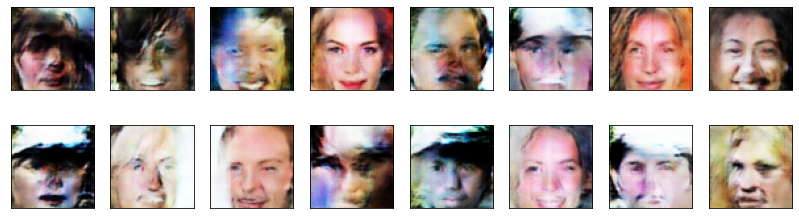

2024-03-27 20:56:00 | Epoch [10/25] | Batch 0/509 | d_loss: 0.4686 | g_loss: 3.1985
2024-03-27 20:56:07 | Epoch [10/25] | Batch 50/509 | d_loss: 0.6312 | g_loss: 2.8437
2024-03-27 20:56:14 | Epoch [10/25] | Batch 100/509 | d_loss: 0.4638 | g_loss: 3.6237
2024-03-27 20:56:20 | Epoch [10/25] | Batch 150/509 | d_loss: 1.0292 | g_loss: 6.8300
2024-03-27 20:56:27 | Epoch [10/25] | Batch 200/509 | d_loss: 0.7213 | g_loss: 3.8626
2024-03-27 20:56:34 | Epoch [10/25] | Batch 250/509 | d_loss: 0.3603 | g_loss: 4.7213
2024-03-27 20:56:40 | Epoch [10/25] | Batch 300/509 | d_loss: 0.3689 | g_loss: 6.4237
2024-03-27 20:56:47 | Epoch [10/25] | Batch 350/509 | d_loss: 0.4242 | g_loss: 5.0710
2024-03-27 20:56:54 | Epoch [10/25] | Batch 400/509 | d_loss: 0.3828 | g_loss: 4.8482
2024-03-27 20:57:00 | Epoch [10/25] | Batch 450/509 | d_loss: 0.4846 | g_loss: 4.6801
2024-03-27 20:57:07 | Epoch [10/25] | Batch 500/509 | d_loss: 0.3952 | g_loss: 3.7809


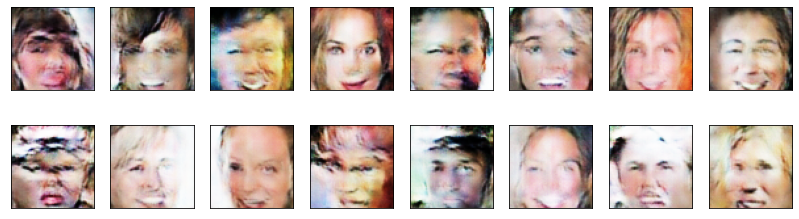

2024-03-27 20:57:13 | Epoch [11/25] | Batch 0/509 | d_loss: 0.5558 | g_loss: 5.1434
2024-03-27 20:57:20 | Epoch [11/25] | Batch 50/509 | d_loss: 0.3398 | g_loss: 5.6792
2024-03-27 20:57:27 | Epoch [11/25] | Batch 100/509 | d_loss: 0.3711 | g_loss: 4.2919
2024-03-27 20:57:34 | Epoch [11/25] | Batch 150/509 | d_loss: 0.3674 | g_loss: 4.4778
2024-03-27 20:57:40 | Epoch [11/25] | Batch 200/509 | d_loss: 0.5837 | g_loss: 2.7749
2024-03-27 20:57:47 | Epoch [11/25] | Batch 250/509 | d_loss: 0.4080 | g_loss: 3.9401
2024-03-27 20:57:54 | Epoch [11/25] | Batch 300/509 | d_loss: 0.4060 | g_loss: 4.9188
2024-03-27 20:58:00 | Epoch [11/25] | Batch 350/509 | d_loss: 0.6192 | g_loss: 3.3789
2024-03-27 20:58:07 | Epoch [11/25] | Batch 400/509 | d_loss: 0.4469 | g_loss: 3.6786
2024-03-27 20:58:13 | Epoch [11/25] | Batch 450/509 | d_loss: 0.4546 | g_loss: 3.1460
2024-03-27 20:58:20 | Epoch [11/25] | Batch 500/509 | d_loss: 0.4213 | g_loss: 3.4264


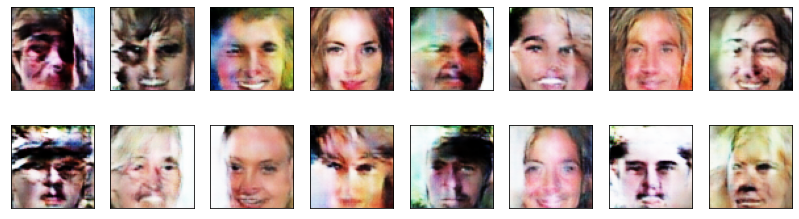

2024-03-27 20:58:25 | Epoch [12/25] | Batch 0/509 | d_loss: 0.4941 | g_loss: 3.9506
2024-03-27 20:58:32 | Epoch [12/25] | Batch 50/509 | d_loss: 0.3703 | g_loss: 4.0380
2024-03-27 20:58:39 | Epoch [12/25] | Batch 100/509 | d_loss: 0.4290 | g_loss: 3.6656
2024-03-27 20:58:45 | Epoch [12/25] | Batch 150/509 | d_loss: 0.4075 | g_loss: 4.0607
2024-03-27 20:58:52 | Epoch [12/25] | Batch 200/509 | d_loss: 0.4593 | g_loss: 3.1401
2024-03-27 20:58:59 | Epoch [12/25] | Batch 250/509 | d_loss: 0.4684 | g_loss: 3.1055
2024-03-27 20:59:06 | Epoch [12/25] | Batch 300/509 | d_loss: 0.5788 | g_loss: 2.0588
2024-03-27 20:59:13 | Epoch [12/25] | Batch 350/509 | d_loss: 0.4115 | g_loss: 3.7499
2024-03-27 20:59:19 | Epoch [12/25] | Batch 400/509 | d_loss: 0.5683 | g_loss: 3.5260
2024-03-27 20:59:26 | Epoch [12/25] | Batch 450/509 | d_loss: 0.5790 | g_loss: 4.4234
2024-03-27 20:59:32 | Epoch [12/25] | Batch 500/509 | d_loss: 0.3925 | g_loss: 4.2187


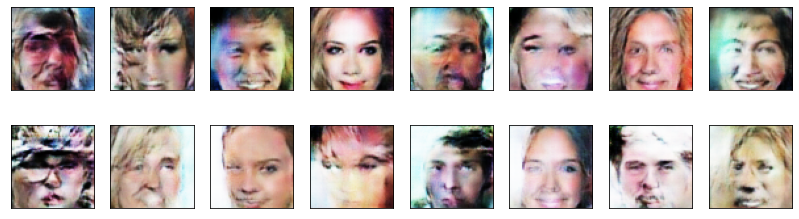

2024-03-27 20:59:38 | Epoch [13/25] | Batch 0/509 | d_loss: 0.4789 | g_loss: 3.1036
2024-03-27 20:59:45 | Epoch [13/25] | Batch 50/509 | d_loss: 0.4414 | g_loss: 2.8622
2024-03-27 20:59:52 | Epoch [13/25] | Batch 100/509 | d_loss: 0.4094 | g_loss: 3.8237
2024-03-27 20:59:58 | Epoch [13/25] | Batch 150/509 | d_loss: 0.4604 | g_loss: 3.2923
2024-03-27 21:00:05 | Epoch [13/25] | Batch 200/509 | d_loss: 0.5168 | g_loss: 3.0700
2024-03-27 21:00:12 | Epoch [13/25] | Batch 250/509 | d_loss: 0.6769 | g_loss: 5.5256
2024-03-27 21:00:19 | Epoch [13/25] | Batch 300/509 | d_loss: 0.4313 | g_loss: 5.9428
2024-03-27 21:00:26 | Epoch [13/25] | Batch 350/509 | d_loss: 0.3682 | g_loss: 4.9437
2024-03-27 21:00:32 | Epoch [13/25] | Batch 400/509 | d_loss: 0.3839 | g_loss: 5.5859
2024-03-27 21:00:39 | Epoch [13/25] | Batch 450/509 | d_loss: 0.4028 | g_loss: 3.9354
2024-03-27 21:00:46 | Epoch [13/25] | Batch 500/509 | d_loss: 0.4262 | g_loss: 2.8088


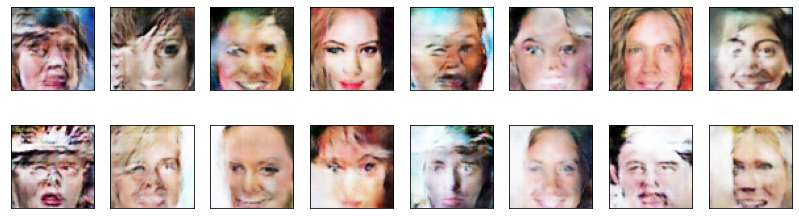

2024-03-27 21:00:52 | Epoch [14/25] | Batch 0/509 | d_loss: 0.4037 | g_loss: 3.5783
2024-03-27 21:00:59 | Epoch [14/25] | Batch 50/509 | d_loss: 0.3637 | g_loss: 4.6918
2024-03-27 21:01:05 | Epoch [14/25] | Batch 100/509 | d_loss: 0.3569 | g_loss: 5.8320
2024-03-27 21:01:12 | Epoch [14/25] | Batch 150/509 | d_loss: 0.4293 | g_loss: 3.2997
2024-03-27 21:01:19 | Epoch [14/25] | Batch 200/509 | d_loss: 0.3467 | g_loss: 6.0329
2024-03-27 21:01:25 | Epoch [14/25] | Batch 250/509 | d_loss: 0.4200 | g_loss: 4.3386
2024-03-27 21:01:32 | Epoch [14/25] | Batch 300/509 | d_loss: 0.4619 | g_loss: 4.6038
2024-03-27 21:01:39 | Epoch [14/25] | Batch 350/509 | d_loss: 0.3623 | g_loss: 5.6591
2024-03-27 21:01:46 | Epoch [14/25] | Batch 400/509 | d_loss: 0.4534 | g_loss: 3.8061
2024-03-27 21:01:52 | Epoch [14/25] | Batch 450/509 | d_loss: 0.5410 | g_loss: 4.1318
2024-03-27 21:01:59 | Epoch [14/25] | Batch 500/509 | d_loss: 0.3761 | g_loss: 4.7486


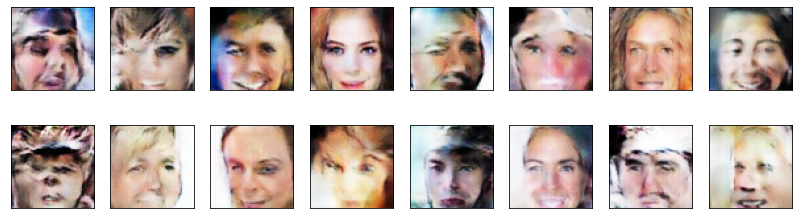

2024-03-27 21:02:04 | Epoch [15/25] | Batch 0/509 | d_loss: 0.3567 | g_loss: 6.4665
2024-03-27 21:02:11 | Epoch [15/25] | Batch 50/509 | d_loss: 0.6296 | g_loss: 3.1052
2024-03-27 21:02:18 | Epoch [15/25] | Batch 100/509 | d_loss: 0.4033 | g_loss: 4.0207
2024-03-27 21:02:24 | Epoch [15/25] | Batch 150/509 | d_loss: 0.3527 | g_loss: 4.4523
2024-03-27 21:02:31 | Epoch [15/25] | Batch 200/509 | d_loss: 0.4190 | g_loss: 5.1240
2024-03-27 21:02:38 | Epoch [15/25] | Batch 250/509 | d_loss: 0.4190 | g_loss: 3.3587
2024-03-27 21:02:44 | Epoch [15/25] | Batch 300/509 | d_loss: 0.3432 | g_loss: 6.2744
2024-03-27 21:02:51 | Epoch [15/25] | Batch 350/509 | d_loss: 0.4272 | g_loss: 3.8134
2024-03-27 21:02:58 | Epoch [15/25] | Batch 400/509 | d_loss: 0.3815 | g_loss: 4.9908
2024-03-27 21:03:05 | Epoch [15/25] | Batch 450/509 | d_loss: 0.4082 | g_loss: 2.7786
2024-03-27 21:03:11 | Epoch [15/25] | Batch 500/509 | d_loss: 0.5220 | g_loss: 3.8153


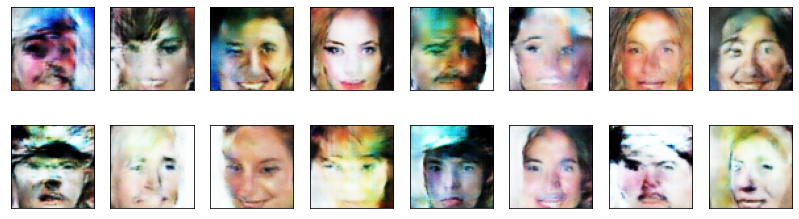

2024-03-27 21:03:17 | Epoch [16/25] | Batch 0/509 | d_loss: 0.3855 | g_loss: 4.6116
2024-03-27 21:03:24 | Epoch [16/25] | Batch 50/509 | d_loss: 1.0493 | g_loss: 0.9953
2024-03-27 21:03:31 | Epoch [16/25] | Batch 100/509 | d_loss: 0.4346 | g_loss: 2.5619
2024-03-27 21:03:37 | Epoch [16/25] | Batch 150/509 | d_loss: 0.3786 | g_loss: 5.8414
2024-03-27 21:03:44 | Epoch [16/25] | Batch 200/509 | d_loss: 0.3675 | g_loss: 7.0664
2024-03-27 21:03:51 | Epoch [16/25] | Batch 250/509 | d_loss: 0.3437 | g_loss: 6.2640
2024-03-27 21:03:58 | Epoch [16/25] | Batch 300/509 | d_loss: 0.5275 | g_loss: 3.2322
2024-03-27 21:04:04 | Epoch [16/25] | Batch 350/509 | d_loss: 0.4501 | g_loss: 4.3324
2024-03-27 21:04:11 | Epoch [16/25] | Batch 400/509 | d_loss: 0.4383 | g_loss: 4.3118
2024-03-27 21:04:18 | Epoch [16/25] | Batch 450/509 | d_loss: 0.4580 | g_loss: 3.4424
2024-03-27 21:04:24 | Epoch [16/25] | Batch 500/509 | d_loss: 0.3629 | g_loss: 5.7262


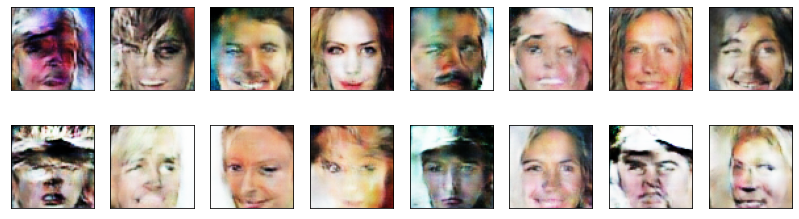

2024-03-27 21:04:30 | Epoch [17/25] | Batch 0/509 | d_loss: 0.5874 | g_loss: 3.5836
2024-03-27 21:04:36 | Epoch [17/25] | Batch 50/509 | d_loss: 0.4348 | g_loss: 3.1675
2024-03-27 21:04:43 | Epoch [17/25] | Batch 100/509 | d_loss: 0.4249 | g_loss: 2.9284
2024-03-27 21:04:50 | Epoch [17/25] | Batch 150/509 | d_loss: 0.3884 | g_loss: 3.6587
2024-03-27 21:04:56 | Epoch [17/25] | Batch 200/509 | d_loss: 0.3537 | g_loss: 4.3938
2024-03-27 21:05:03 | Epoch [17/25] | Batch 250/509 | d_loss: 0.3462 | g_loss: 5.6496
2024-03-27 21:05:10 | Epoch [17/25] | Batch 300/509 | d_loss: 0.7196 | g_loss: 4.5871
2024-03-27 21:05:16 | Epoch [17/25] | Batch 350/509 | d_loss: 0.5117 | g_loss: 4.3818
2024-03-27 21:05:23 | Epoch [17/25] | Batch 400/509 | d_loss: 0.3620 | g_loss: 4.5607
2024-03-27 21:05:30 | Epoch [17/25] | Batch 450/509 | d_loss: 0.4026 | g_loss: 5.0627
2024-03-27 21:05:36 | Epoch [17/25] | Batch 500/509 | d_loss: 0.4307 | g_loss: 4.8857


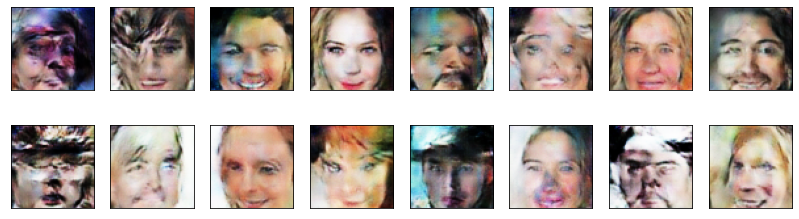

2024-03-27 21:05:43 | Epoch [18/25] | Batch 0/509 | d_loss: 0.3498 | g_loss: 6.0212
2024-03-27 21:05:50 | Epoch [18/25] | Batch 50/509 | d_loss: 0.4847 | g_loss: 4.4044
2024-03-27 21:05:56 | Epoch [18/25] | Batch 100/509 | d_loss: 0.4882 | g_loss: 2.8429
2024-03-27 21:06:03 | Epoch [18/25] | Batch 150/509 | d_loss: 0.3459 | g_loss: 6.0957
2024-03-27 21:06:10 | Epoch [18/25] | Batch 200/509 | d_loss: 0.3744 | g_loss: 3.9302
2024-03-27 21:06:17 | Epoch [18/25] | Batch 250/509 | d_loss: 0.3672 | g_loss: 6.7705
2024-03-27 21:06:23 | Epoch [18/25] | Batch 300/509 | d_loss: 0.4221 | g_loss: 3.5763
2024-03-27 21:06:30 | Epoch [18/25] | Batch 350/509 | d_loss: 0.6063 | g_loss: 3.1307
2024-03-27 21:06:37 | Epoch [18/25] | Batch 400/509 | d_loss: 0.6253 | g_loss: 3.1708
2024-03-27 21:06:44 | Epoch [18/25] | Batch 450/509 | d_loss: 0.5189 | g_loss: 4.2657
2024-03-27 21:06:50 | Epoch [18/25] | Batch 500/509 | d_loss: 0.4863 | g_loss: 3.5921


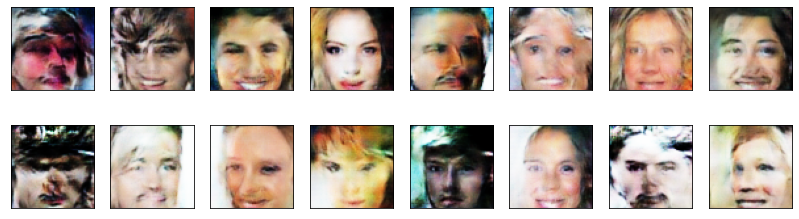

2024-03-27 21:06:56 | Epoch [19/25] | Batch 0/509 | d_loss: 0.4254 | g_loss: 4.0146
2024-03-27 21:07:03 | Epoch [19/25] | Batch 50/509 | d_loss: 0.3980 | g_loss: 5.0966
2024-03-27 21:07:09 | Epoch [19/25] | Batch 100/509 | d_loss: 0.3726 | g_loss: 4.9356
2024-03-27 21:07:16 | Epoch [19/25] | Batch 150/509 | d_loss: 0.3905 | g_loss: 4.3418
2024-03-27 21:07:23 | Epoch [19/25] | Batch 200/509 | d_loss: 0.5889 | g_loss: 4.9350
2024-03-27 21:07:30 | Epoch [19/25] | Batch 250/509 | d_loss: 0.4156 | g_loss: 3.4019
2024-03-27 21:07:36 | Epoch [19/25] | Batch 300/509 | d_loss: 0.4498 | g_loss: 4.1134
2024-03-27 21:07:43 | Epoch [19/25] | Batch 350/509 | d_loss: 0.4967 | g_loss: 3.1182
2024-03-27 21:07:50 | Epoch [19/25] | Batch 400/509 | d_loss: 0.7204 | g_loss: 3.8028
2024-03-27 21:07:56 | Epoch [19/25] | Batch 450/509 | d_loss: 0.3693 | g_loss: 4.4788
2024-03-27 21:08:03 | Epoch [19/25] | Batch 500/509 | d_loss: 0.4756 | g_loss: 4.4860


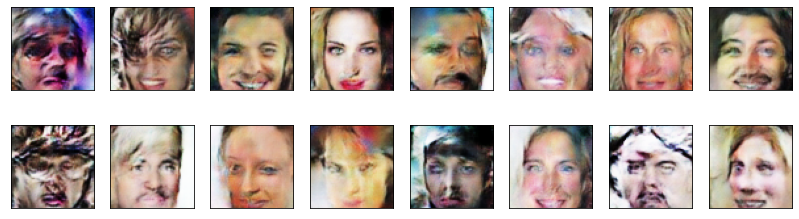

2024-03-27 21:08:09 | Epoch [20/25] | Batch 0/509 | d_loss: 0.3611 | g_loss: 4.1125
2024-03-27 21:08:16 | Epoch [20/25] | Batch 50/509 | d_loss: 0.4435 | g_loss: 4.3283
2024-03-27 21:08:22 | Epoch [20/25] | Batch 100/509 | d_loss: 0.3559 | g_loss: 6.2744
2024-03-27 21:08:29 | Epoch [20/25] | Batch 150/509 | d_loss: 0.4378 | g_loss: 3.8593
2024-03-27 21:08:36 | Epoch [20/25] | Batch 200/509 | d_loss: 0.4517 | g_loss: 3.8782
2024-03-27 21:08:43 | Epoch [20/25] | Batch 250/509 | d_loss: 0.3669 | g_loss: 4.3834
2024-03-27 21:08:49 | Epoch [20/25] | Batch 300/509 | d_loss: 0.3708 | g_loss: 3.9954
2024-03-27 21:08:56 | Epoch [20/25] | Batch 350/509 | d_loss: 0.4319 | g_loss: 5.0545
2024-03-27 21:09:03 | Epoch [20/25] | Batch 400/509 | d_loss: 0.3636 | g_loss: 4.8357
2024-03-27 21:09:09 | Epoch [20/25] | Batch 450/509 | d_loss: 0.4060 | g_loss: 3.9716
2024-03-27 21:09:16 | Epoch [20/25] | Batch 500/509 | d_loss: 0.3609 | g_loss: 4.6640


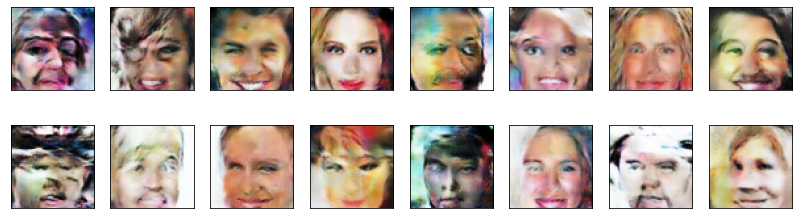

2024-03-27 21:09:21 | Epoch [21/25] | Batch 0/509 | d_loss: 0.4477 | g_loss: 4.2808
2024-03-27 21:09:28 | Epoch [21/25] | Batch 50/509 | d_loss: 0.3871 | g_loss: 3.9637
2024-03-27 21:09:35 | Epoch [21/25] | Batch 100/509 | d_loss: 0.3879 | g_loss: 3.3616
2024-03-27 21:09:41 | Epoch [21/25] | Batch 150/509 | d_loss: 4.1625 | g_loss: 8.9334
2024-03-27 21:09:48 | Epoch [21/25] | Batch 200/509 | d_loss: 0.6149 | g_loss: 3.2222
2024-03-27 21:09:55 | Epoch [21/25] | Batch 250/509 | d_loss: 0.5061 | g_loss: 3.3020
2024-03-27 21:10:02 | Epoch [21/25] | Batch 300/509 | d_loss: 0.7642 | g_loss: 4.4849
2024-03-27 21:10:08 | Epoch [21/25] | Batch 350/509 | d_loss: 0.3961 | g_loss: 3.8981
2024-03-27 21:10:15 | Epoch [21/25] | Batch 400/509 | d_loss: 0.4238 | g_loss: 3.8898
2024-03-27 21:10:22 | Epoch [21/25] | Batch 450/509 | d_loss: 0.3901 | g_loss: 4.2843
2024-03-27 21:10:28 | Epoch [21/25] | Batch 500/509 | d_loss: 0.3560 | g_loss: 4.7690


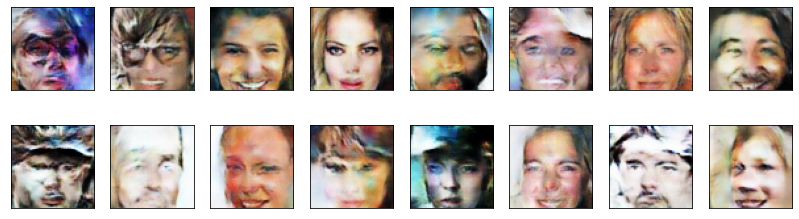

2024-03-27 21:10:33 | Epoch [22/25] | Batch 0/509 | d_loss: 0.3792 | g_loss: 4.9374
2024-03-27 21:10:40 | Epoch [22/25] | Batch 50/509 | d_loss: 0.4887 | g_loss: 3.8669
2024-03-27 21:10:47 | Epoch [22/25] | Batch 100/509 | d_loss: 0.8273 | g_loss: 3.7274
2024-03-27 21:10:53 | Epoch [22/25] | Batch 150/509 | d_loss: 0.4999 | g_loss: 3.0898
2024-03-27 21:11:00 | Epoch [22/25] | Batch 200/509 | d_loss: 0.4179 | g_loss: 4.1018
2024-03-27 21:11:07 | Epoch [22/25] | Batch 250/509 | d_loss: 0.3650 | g_loss: 4.9396
2024-03-27 21:11:13 | Epoch [22/25] | Batch 300/509 | d_loss: 0.3997 | g_loss: 3.6284
2024-03-27 21:11:20 | Epoch [22/25] | Batch 350/509 | d_loss: 0.3639 | g_loss: 4.9400
2024-03-27 21:11:27 | Epoch [22/25] | Batch 400/509 | d_loss: 0.3746 | g_loss: 5.0410
2024-03-27 21:11:33 | Epoch [22/25] | Batch 450/509 | d_loss: 0.3590 | g_loss: 3.8422
2024-03-27 21:11:40 | Epoch [22/25] | Batch 500/509 | d_loss: 0.5289 | g_loss: 3.0383


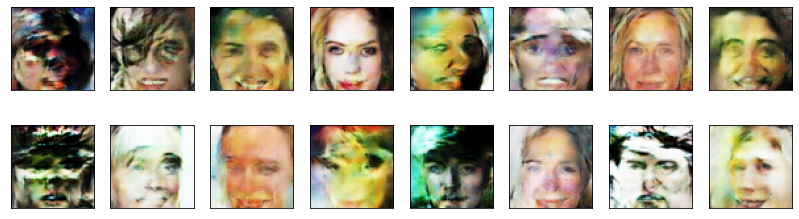

2024-03-27 21:11:46 | Epoch [23/25] | Batch 0/509 | d_loss: 0.4153 | g_loss: 3.2671
2024-03-27 21:11:53 | Epoch [23/25] | Batch 50/509 | d_loss: 0.4614 | g_loss: 4.2324
2024-03-27 21:12:00 | Epoch [23/25] | Batch 100/509 | d_loss: 0.3993 | g_loss: 3.4893
2024-03-27 21:12:07 | Epoch [23/25] | Batch 150/509 | d_loss: 0.3632 | g_loss: 5.0713
2024-03-27 21:12:13 | Epoch [23/25] | Batch 200/509 | d_loss: 0.3790 | g_loss: 4.2895
2024-03-27 21:12:20 | Epoch [23/25] | Batch 250/509 | d_loss: 0.4429 | g_loss: 2.6898
2024-03-27 21:12:27 | Epoch [23/25] | Batch 300/509 | d_loss: 0.3701 | g_loss: 4.2225
2024-03-27 21:12:33 | Epoch [23/25] | Batch 350/509 | d_loss: 0.8319 | g_loss: 0.4701
2024-03-27 21:12:40 | Epoch [23/25] | Batch 400/509 | d_loss: 0.3830 | g_loss: 4.3158
2024-03-27 21:12:47 | Epoch [23/25] | Batch 450/509 | d_loss: 0.3757 | g_loss: 3.6521
2024-03-27 21:12:53 | Epoch [23/25] | Batch 500/509 | d_loss: 0.4573 | g_loss: 4.5509


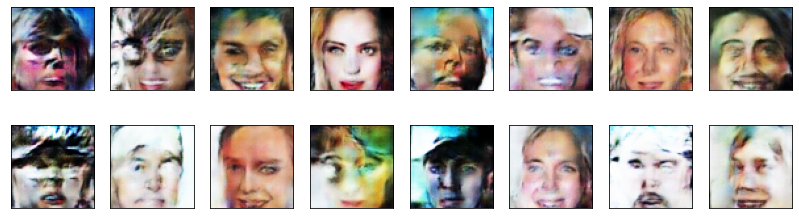

2024-03-27 21:12:58 | Epoch [24/25] | Batch 0/509 | d_loss: 0.4347 | g_loss: 3.1424
2024-03-27 21:13:05 | Epoch [24/25] | Batch 50/509 | d_loss: 0.4344 | g_loss: 2.8990
2024-03-27 21:13:12 | Epoch [24/25] | Batch 100/509 | d_loss: 0.3749 | g_loss: 3.8019
2024-03-27 21:13:19 | Epoch [24/25] | Batch 150/509 | d_loss: 0.3452 | g_loss: 5.7955
2024-03-27 21:13:25 | Epoch [24/25] | Batch 200/509 | d_loss: 0.3665 | g_loss: 4.4848
2024-03-27 21:13:32 | Epoch [24/25] | Batch 250/509 | d_loss: 0.5027 | g_loss: 3.3704
2024-03-27 21:13:39 | Epoch [24/25] | Batch 300/509 | d_loss: 0.4144 | g_loss: 3.8182
2024-03-27 21:13:46 | Epoch [24/25] | Batch 350/509 | d_loss: 0.3814 | g_loss: 4.3738
2024-03-27 21:13:52 | Epoch [24/25] | Batch 400/509 | d_loss: 0.4328 | g_loss: 3.7990
2024-03-27 21:13:59 | Epoch [24/25] | Batch 450/509 | d_loss: 0.4347 | g_loss: 3.6571
2024-03-27 21:14:06 | Epoch [24/25] | Batch 500/509 | d_loss: 0.5603 | g_loss: 3.9340


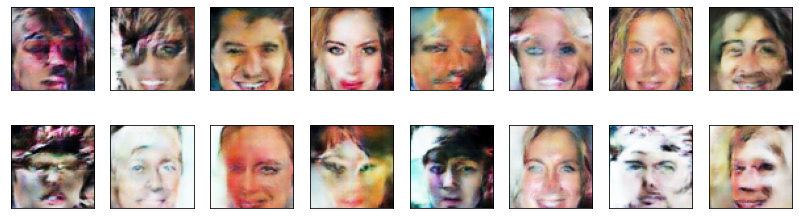

2024-03-27 21:14:11 | Epoch [25/25] | Batch 0/509 | d_loss: 0.3702 | g_loss: 3.7000
2024-03-27 21:14:17 | Epoch [25/25] | Batch 50/509 | d_loss: 0.5801 | g_loss: 3.6062
2024-03-27 21:14:24 | Epoch [25/25] | Batch 100/509 | d_loss: 0.4522 | g_loss: 3.1853
2024-03-27 21:14:31 | Epoch [25/25] | Batch 150/509 | d_loss: 0.3696 | g_loss: 5.4724
2024-03-27 21:14:37 | Epoch [25/25] | Batch 200/509 | d_loss: 0.4485 | g_loss: 3.9961
2024-03-27 21:14:44 | Epoch [25/25] | Batch 250/509 | d_loss: 0.8131 | g_loss: 6.5999
2024-03-27 21:14:51 | Epoch [25/25] | Batch 300/509 | d_loss: 0.3689 | g_loss: 4.4991
2024-03-27 21:14:58 | Epoch [25/25] | Batch 350/509 | d_loss: 0.3759 | g_loss: 4.0409
2024-03-27 21:15:05 | Epoch [25/25] | Batch 400/509 | d_loss: 0.4823 | g_loss: 3.2427
2024-03-27 21:15:11 | Epoch [25/25] | Batch 450/509 | d_loss: 0.3497 | g_loss: 7.1888
2024-03-27 21:15:18 | Epoch [25/25] | Batch 500/509 | d_loss: 0.3626 | g_loss: 4.4154


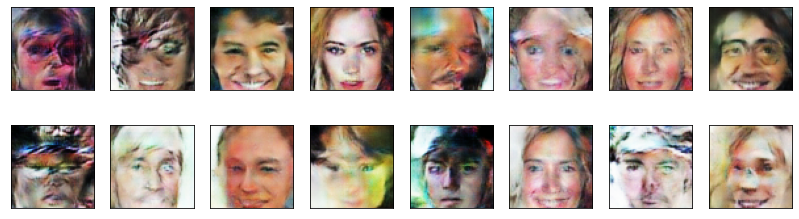

In [67]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        real_images = scale(real_images)
        ####################################
        
        # TODO: implement the training strategy
               
        d_loss = discriminator_step(batch_size, latent_dim, real_images)
        
        g_loss = generator_step(batch_size, latent_dim)
        
        ####################################
        
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
            save_model(discriminator, generator, d_optimizer, g_optimizer)
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

with open('generated_images.pkl', 'wb') as f:
    pkl.dump(generated_images, f)

### Training losses

Plot the training losses for the generator and discriminator.

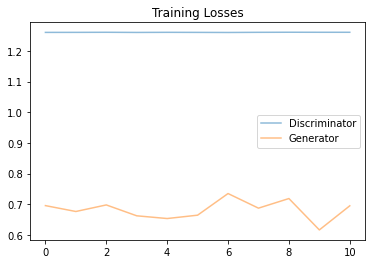

In [52]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** (it generated and still to the human not good enough and we can imporve it by addain gradient penlty and remove batch normlization in order to add it)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.